#### Tumor Tissue Classification
The following notebook is for tissue classification of a given sequence. The tissues classified are according to the given labels. 

#### Load Environment

In [70]:
import pandas as pd
import collections
import numpy as np
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# feature scaling
from sklearn.preprocessing import StandardScaler
# roc curve
from sklearn.metrics import roc_curve, auc


#### Load Data

In [74]:
embedding_data = pd.read_pickle('/home/ubuntu/CRC_Project/single_cell_data/GSE164522_colon_data/GSE164522_all_labels_embeddings.pkl')
embedding_data

,0,1,2,3,4,5,6,7,8,9,...,765,766,767,Sequences,barcode,patient,cdr3_nt,v_gene,j_gene,label
0,0.139004,-0.834601,0.428743,-0.579141,0.180653,-0.248555,0.624803,0.133400,0.605922,-0.134171,...,0.495849,0.369196,0.755795,CAARDGQKLLF,CAAGAAATCAGGCAAG-1,P08,TGCGCCGCTCGAGATGGCCAGAAGCTGCTCTTT,TRAV1-1,TRAJ16,MT
1,0.242866,0.107675,0.538315,-0.003720,-0.375084,-0.112362,0.372618,-0.322024,0.180878,0.242466,...,-0.433212,0.022644,0.391947,CAPRDAGNMLTF,CCGTACTAGAGGTACC-1,P08,TGCGCTCCCAGAGACGCAGGCAACATGCTCACCTTT,TRAV1-1,TRAJ39,PT
2,0.527857,-0.015186,-0.099201,0.873151,0.321454,-0.518015,0.380253,-0.651731,-0.430548,0.373503,...,-0.311736,-0.077450,1.131234,CAPWRANNLFF,CAGGTGCGTATTAGCC-1,P08,TGCGCTCCGTGGAGGGCAAACAACCTCTTCTTT,TRAV1-1,TRAJ36,MN
3,0.503886,-0.293327,0.307653,-0.069019,1.049926,-0.553218,0.072750,-0.048932,1.003164,-0.667713,...,0.393718,-0.411088,0.108976,CAENDYKLSF,TGACGGCTCGTCGTTC-1,P08,TGCGCTGAGAACGACTACAAGCTCAGCTTT,TRAV1-1,TRAJ20,MT
4,0.513439,0.151764,0.743720,0.263346,0.009222,-0.121522,0.986420,0.354586,0.230940,-0.072103,...,1.029758,0.110704,0.149979,CAGGYNQGGKLIF,CGGACGTTCGCTTAGA-1,P08,TGCGCTGGGGGCTATAACCAGGGAGGAAAGCTTATCTTC,TRAV1-1,TRAJ23,PN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165289,0.822896,0.555660,0.172111,0.194957,0.445394,-0.241407,0.364384,-0.868294,0.670279,-0.371477,...,0.229063,0.031383,1.015477,CSVEGEREFSDTQYF,GTTCGGGCATTCTCAT-1,P17,TGCAGCGTTGAGGGTGAGCGGGAGTTTTCAGATACGCAGTATTTT,TRBV29-1,TRBJ2-3,MT
165290,0.537573,-0.059037,0.395545,0.078258,0.460128,-0.176501,0.413896,0.561076,0.535223,0.010178,...,0.154649,-0.017331,-0.450605,CASSYDSGREQFF,ACGATACCAAGTACCT-1,P17,TGTGCCAGCAGTTATGATAGTGGACGCGAGCAGTTCTTC,TRBV5-4,TRBJ2-1,LN
165291,0.659176,-0.210888,0.644329,0.712713,0.161707,-0.212158,0.042726,0.627335,1.072471,0.148473,...,0.215280,0.113033,0.160168,CASSVGTSGGADEQFF,TGAGAGGAGCGAAGGG-1,P17,TGTGCCAGCAGCGTAGGGACTAGCGGGGGGGCTGATGAGCAGTTCTTC,TRBV9,TRBJ2-1,LN
165292,0.511918,-0.361814,1.083696,0.155230,0.268411,0.109573,0.233870,-0.139599,0.281118,0.229138,...,0.088696,-0.101209,-0.139330,CASSLTSGSSQETQYF,GGTATTGAGGTGCAAC-1,P17,TGTGCCAGCAGCTTGACTAGCGGGAGTTCACAAGAGACCCAGTACTTC,TRBV5-5,TRBJ2-5,MT


In [67]:
# add cdr3_nt column to be last column
cdr3_nt = embedding_data['cdr3_nt']
embedding_data = embedding_data.drop(columns=['cdr3_nt'])
embedding_data['cdr3_nt'] = cdr3_nt
embedding_data

,0,1,2,3,4,5,6,7,8,9,...,765,766,767,Sequences,barcode,patient,v_gene,j_gene,label,cdr3_nt
0,0.139004,-0.834601,0.428743,-0.579141,0.180653,-0.248555,0.624803,0.133400,0.605922,-0.134171,...,0.495849,0.369196,0.755795,CAARDGQKLLF,CAAGAAATCAGGCAAG-1,P08,TRAV1-1,TRAJ16,MT,TGCGCCGCTCGAGATGGCCAGAAGCTGCTCTTT
1,0.242866,0.107675,0.538315,-0.003720,-0.375084,-0.112362,0.372618,-0.322024,0.180878,0.242466,...,-0.433212,0.022644,0.391947,CAPRDAGNMLTF,CCGTACTAGAGGTACC-1,P08,TRAV1-1,TRAJ39,PT,TGCGCTCCCAGAGACGCAGGCAACATGCTCACCTTT
2,0.527857,-0.015186,-0.099201,0.873151,0.321454,-0.518015,0.380253,-0.651731,-0.430548,0.373503,...,-0.311736,-0.077450,1.131234,CAPWRANNLFF,CAGGTGCGTATTAGCC-1,P08,TRAV1-1,TRAJ36,MN,TGCGCTCCGTGGAGGGCAAACAACCTCTTCTTT
3,0.503886,-0.293327,0.307653,-0.069019,1.049926,-0.553218,0.072750,-0.048932,1.003164,-0.667713,...,0.393718,-0.411088,0.108976,CAENDYKLSF,TGACGGCTCGTCGTTC-1,P08,TRAV1-1,TRAJ20,MT,TGCGCTGAGAACGACTACAAGCTCAGCTTT
4,0.513439,0.151764,0.743720,0.263346,0.009222,-0.121522,0.986420,0.354586,0.230940,-0.072103,...,1.029758,0.110704,0.149979,CAGGYNQGGKLIF,CGGACGTTCGCTTAGA-1,P08,TRAV1-1,TRAJ23,PN,TGCGCTGGGGGCTATAACCAGGGAGGAAAGCTTATCTTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165289,0.822896,0.555660,0.172111,0.194957,0.445394,-0.241407,0.364384,-0.868294,0.670279,-0.371477,...,0.229063,0.031383,1.015477,CSVEGEREFSDTQYF,GTTCGGGCATTCTCAT-1,P17,TRBV29-1,TRBJ2-3,MT,TGCAGCGTTGAGGGTGAGCGGGAGTTTTCAGATACGCAGTATTTT
165290,0.537573,-0.059037,0.395545,0.078258,0.460128,-0.176501,0.413896,0.561076,0.535223,0.010178,...,0.154649,-0.017331,-0.450605,CASSYDSGREQFF,ACGATACCAAGTACCT-1,P17,TRBV5-4,TRBJ2-1,LN,TGTGCCAGCAGTTATGATAGTGGACGCGAGCAGTTCTTC
165291,0.659176,-0.210888,0.644329,0.712713,0.161707,-0.212158,0.042726,0.627335,1.072471,0.148473,...,0.215280,0.113033,0.160168,CASSVGTSGGADEQFF,TGAGAGGAGCGAAGGG-1,P17,TRBV9,TRBJ2-1,LN,TGTGCCAGCAGCGTAGGGACTAGCGGGGGGGCTGATGAGCAGTTCTTC
165292,0.511918,-0.361814,1.083696,0.155230,0.268411,0.109573,0.233870,-0.139599,0.281118,0.229138,...,0.088696,-0.101209,-0.139330,CASSLTSGSSQETQYF,GGTATTGAGGTGCAAC-1,P17,TRBV5-5,TRBJ2-5,MT,TGTGCCAGCAGCTTGACTAGCGGGAGTTCACAAGAGACCCAGTACTTC


In [75]:
# look at label distribution
collections.Counter(embedding_data['label'])

Counter({'PBMC': 31244,
         'MN': 31221,
         'MT': 30450,
         'PT': 29752,
         'LN': 27527,
         'PN': 15100})

##### Subset data wit an external sequence list
If applicable, the following code enables to upliad another dataframe and create a list of the desired sequences to subset by. 

In [79]:
specific_sequences = pd.read_csv('~/CRC_Project/single_cell_data/zhang_gse164522_common_sequences.csv')
embedding_data_sampled = embedding_data.copy()
embedding_data_sampled['common_label'] = embedding_data['cdr3_aa'].isin(specific_sequences['cdr3_aa'])
embedding_data_sampled = embedding_data_sampled[embedding_data_sampled['common_label'] == True]
embedding_data_sampled.drop(labels=['common_label'],axis=1, inplace=True)
embedding_data_sampled

In [77]:
collections.Counter(embedding_data_sampled['label'])

Counter({'PBMC': 31244,
         'MN': 31221,
         'MT': 30450,
         'PT': 29752,
         'LN': 27527,
         'PN': 15100})

#### Subset data

In [40]:
# use either the full dataset or the sampled dataset
EMBEDDINGS = embedding_data_sampled # embedding_data

In [56]:
# Decide which 2 tissues to compare
tissue1 = 'MN' # PBMC # PT # MT
tissue2 = 'PN' # MT # PT # PN

# subset the data
embedding_data_tissue1 = EMBEDDINGS[EMBEDDINGS['label'] == tissue1]
embedding_data_tissue2 = EMBEDDINGS[EMBEDDINGS['label'] == tissue2]

# if the length of the data is more that 10% greater than the other, sample the data by the smaller length
if len(embedding_data_tissue1) > 1.1 * len(embedding_data_tissue2):
    embedding_data_tissue1 = embedding_data_tissue1.sample(n=len(embedding_data_tissue2))
elif len(embedding_data_tissue2) > 1.1 * len(embedding_data_tissue1):
    embedding_data_tissue2 = embedding_data_tissue2.sample(n=len(embedding_data_tissue1))

# join the two dataframes
embedding_data_sampled = pd.concat([embedding_data_tissue1, embedding_data_tissue2], ignore_index=True)
collections.Counter(embedding_data_sampled['label'])

In [58]:
LABEL_COL = 'label'

# save the chain, cdr3, v_gene, j_gene and cdr3_nt columns to a new dataframe
cdr3_nt = embedding_data_sampled['cdr3_nt']
cdr3 = embedding_data_sampled['cdr3_aa']
v_gene = embedding_data_sampled['v_gene']
patient = embedding_data_sampled['patient']
barcode = embedding_data_sampled['barcode']
j_gene = embedding_data_sampled['j_gene']
label = embedding_data_sampled[LABEL_COL]

cdr3_nt_df = pd.DataFrame({'cdr3_nt': cdr3_nt, 'cdr3': cdr3, 'v_gene': v_gene, 'j_gene': j_gene, 'label': label, 'patient': patient, 'barcode': barcode})

# drop the columns from the original dataframe
embedding_data_sampled.drop(labels=['cdr3_nt', 'cdr3_aa', 'v_gene', 'j_gene', LABEL_COL, 'barcode', 'patient'], axis=1, inplace=True)

embedding_data_sampled

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.413707,0.241206,0.393354,-0.720652,0.902303,0.934271,0.138995,0.948133,1.029166,-0.548008,...,-2.128014,-1.481634,0.896247,-1.338849,0.273937,-0.221600,-0.150005,0.721161,0.249103,1.666394
1,-0.413707,0.241206,0.393354,-0.720652,0.902303,0.934271,0.138995,0.948133,1.029166,-0.548008,...,-2.128014,-1.481634,0.896247,-1.338849,0.273937,-0.221600,-0.150005,0.721161,0.249103,1.666394
2,-0.463383,0.214503,1.909529,-0.984432,1.402809,0.544117,-0.639989,0.145898,1.004060,0.284245,...,-0.389183,-0.204565,1.948691,-0.028484,1.088113,-0.476204,-0.100791,-0.079536,-0.167938,0.804715
3,0.130583,-0.259471,1.846126,-1.866428,1.543722,0.969991,-0.053408,0.410627,0.457063,0.265805,...,-0.938053,-0.644855,1.473522,-0.761983,1.011000,-0.284333,0.189594,-0.859043,-0.068318,0.665519
4,-0.398090,0.061455,0.544338,-0.400898,0.804733,0.619596,-0.070497,0.421905,0.223471,-0.644326,...,-0.884910,0.507319,0.662748,-0.884483,-0.238054,0.900413,0.249345,-0.861741,0.783882,1.609686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1.429756,-0.570589,-0.347181,0.280217,1.098748,1.159624,-0.833213,-0.356062,0.599107,0.417266,...,-1.566842,-0.173540,1.118719,-1.766422,0.541252,-0.281677,0.743108,-0.178831,1.038445,0.559096
668,1.390869,0.341640,0.097726,0.491793,0.830231,0.994021,-0.969683,-0.487488,0.743077,0.529353,...,-0.755049,-1.145716,1.837625,-1.611880,0.604413,-1.111144,0.717248,0.294681,0.119235,0.484571
669,-0.221961,-0.048425,0.154803,0.857007,-0.020003,0.222888,0.340569,-0.053015,-0.017205,0.943804,...,-0.930955,0.155841,-0.324495,-1.705861,-0.170100,0.295662,0.468864,-0.139035,1.107188,0.744083
670,1.115291,0.334600,1.630364,-1.394274,1.720792,0.402296,0.220209,0.306280,-0.430567,-0.232688,...,-1.864551,-1.463543,1.374488,-2.042116,0.653396,-0.659667,0.843650,0.552872,0.971004,0.635598


In [59]:
embeddings = embedding_data_sampled.iloc[:,0:768].to_numpy()
label_array = cdr3_nt_df['label'].to_numpy()

# convert the labels to integers
embedding_labels = np.where(label_array == label_array[0], 0, 1)
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (672, 768)
shape of embedding_labels: (672,)


##### Split Data

In [ ]:
from utils import split_train_test, xgb_classify, plot_roc_curve

In [60]:
TRAIN_RATIO = 0.8

train_embeddings, train_labels, validation_embeddings, validation_labels = split_train_test(embeddings, embedding_labels, TRAIN_RATIO)

In [61]:
# split the data into train and validation sets
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

# check even distribution of labels
collections.Counter(embed_validation_labels), collections.Counter(embed_train_labels)

(Counter({1: 78, 0: 57}), Counter({0: 279, 1: 258}))

In [62]:
sc = StandardScaler()

train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

##### xgBoost

In [64]:
# extract accuracy
accuracy_xgb, xgb_preds, xgb_classifier = xgb_classify(train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels)
accuracy_xgb

75.55555555555556

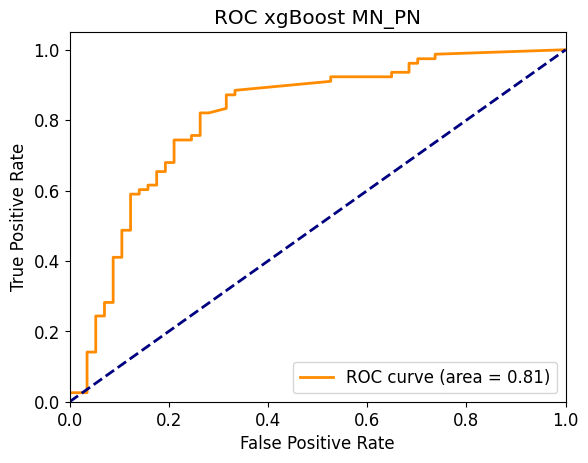

In [65]:
# get probabilities
probs = xgb_classifier.predict_proba(validation_embeddings)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# plot the roc curve
figure_path = '/home/ubuntu/CRC_Project/single_cell_data/GSE164522_colon_data/plots/GSE164522_' + tissue1 + '_' + tissue2 +'_CRC_seq_roc_curve_xgb.png'
plot_roc_curve(fpr_xgb, tpr_xgb, roc_auc_xgb, tissue1, tissue2, figure_path)

##### LDA

In [17]:
from utils import lda_classify

In [18]:
# apply LDA
accuracy_lda, lda_preds, lda_classifier = lda_classify(train_embeddings,embed_train_labels, validation_embeddings, embed_validation_labels)
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

accuracy_lda

57.97438882421421

In [ ]:
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

# plot the roc curve
figure_path_lda = '/home/ubuntu/CRC_Project/single_cell_data/GSE164522_colon_data/plots/GSE164522_' + tissue1 + '_' + tissue2 +'_CRC_seq_roc_curve_lda.png'
plot_roc_curve(fpr_lda, tpr_lda, roc_auc_lda, tissue1, tissue2, figure_path_lda)